In [1]:
# libraries
import os
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import f_oneway

In [2]:
# functions

def read_swc(file_path):
    """
    Reads an SWC file and returns its data as a pandas DataFrame.
    """
    columns = ["ID", "Type", "X", "Y", "Z", "Radius", "Parent"]
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            if not line.startswith("#"):  # Skip comments
                parts = line.strip().split()
                if len(parts) == 7:
                    data.append([int(parts[0]), int(parts[1]), 
                                 float(parts[2]), float(parts[3]), 
                                 float(parts[4]), float(parts[5]), 
                                 int(parts[6])])
    return pd.DataFrame(data, columns=columns)

def calculate_segment_lengths(df):
    """
    Calculates the length of each segment in the SWC file based on parent-child node pairs.
    """
    total_length = 0
    for index, row in df.iterrows():
        parent_id = row["Parent"]
        if parent_id != -1:  # Skip the root node (no parent)
            parent_row = df.loc[df["ID"] == parent_id].iloc[0]
            length = np.sqrt((row["X"] - parent_row["X"])**2 +
                             (row["Y"] - parent_row["Y"])**2 +
                             (row["Z"] - parent_row["Z"])**2)
            total_length += length
    return total_length

def process_batch(directory):
    """
    Reads a batch of SWC files in a directory and analyzes them.
    """
    results = []
    for file_name in os.listdir(directory):
        if file_name.endswith(".swc"):
            file_path = os.path.join(directory, file_name)
            df = read_swc(file_path)
            total_length = calculate_segment_lengths(df)
            results.append({"File": file_name, "Total_Length": total_length})
    return pd.DataFrame(results)

def visualize_neuron(df):
    """
    Visualizes the neuronal morphology in 3D.
    """
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot segments
    for _, row in df.iterrows():
        parent_id = row["Parent"]
        if parent_id != -1:  # Skip root node
            parent_row = df.loc[df["ID"] == parent_id].iloc[0]
            ax.plot([row["X"], parent_row["X"]],
                    [row["Y"], parent_row["Y"]],
                    [row["Z"], parent_row["Z"]],
                    color='b', linewidth=1)
    
    # Highlight soma
    soma = df[df["Type"] == 1]
    ax.scatter(soma["X"], soma["Y"], soma["Z"], color='r', s=50, label="Soma")
    
    ax.set_xlabel("X (µm)")
    ax.set_ylabel("Y (µm)")
    ax.set_zlabel("Z (µm)")
    ax.set_title("3D Visualization of Neuron")
    plt.legend()
    plt.show()



In [3]:
# Set a global Seaborn theme
sns.set_theme(style="whitegrid", palette="pastel", font="sans-serif", font_scale=1.2)

Visualization of a random GABAergic neuron

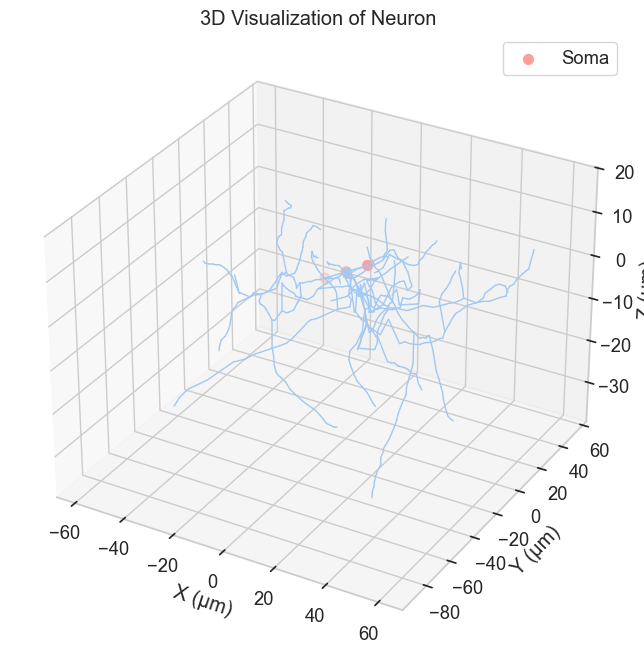

In [4]:
# Loading and visualizing - Neocortex
swc_file = "PDE1c_vGluT2-ctrl_IN31.CNG.swc"
df_view = read_swc(os.path.join("data", "anstoetz","CNG version",swc_file))
visualize_neuron(df_view)

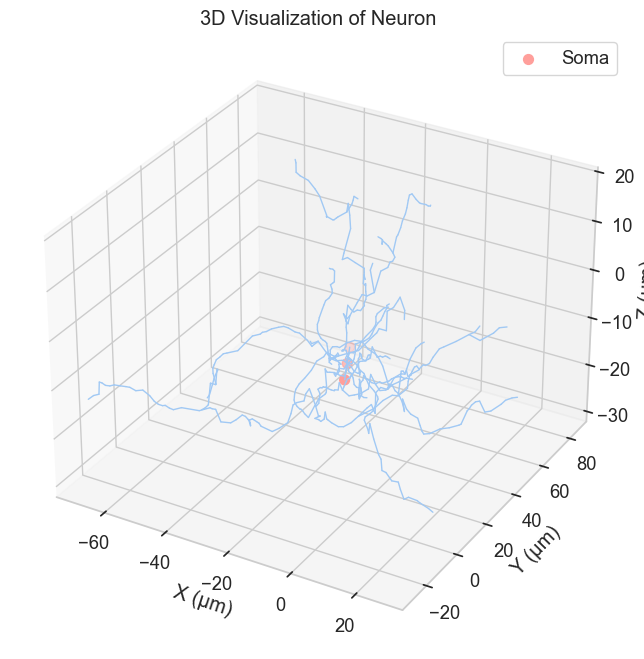

In [5]:
# Loading and visualizing - Hippocampus
swc_file = "p73_vGluT2-ctrl_IN04.CNG.swc"
df_view = read_swc(os.path.join("data", "anstoetz","CNG version",swc_file))
visualize_neuron(df_view)

Creating pooled df from files

In [6]:
# create two pooled df
def pooling_swc_data(directory):
    df = pd.DataFrame()
    for file_name in os.listdir(directory):
        if file_name.endswith(".swc"):
                df_tmp = read_swc(os.path.join(directory, file_name))
                df_tmp['File'] = file_name
                df = pd.concat([df,df_tmp])
    return df

df_neocortex = pooling_swc_data(os.path.join("data", "allen cell types","CNG version"))
df_hippocampus = pooling_swc_data(os.path.join("data", "anstoetz","CNG version"))

In [7]:
def remove_outliers_zscore(df, column, threshold=3):
    # Compute Z-scores for the specified column
    df['Z-Score'] = zscore(df[column])
    
    # Filter the DataFrame to remove outliers
    filtered_df = df[df['Z-Score'].abs() <= threshold].drop(columns=['Z-Score'])
    
    return filtered_df

In [8]:
# lengths of neurons
df_neocortex_length = process_batch(os.path.join("data", "allen cell types","CNG version"))
df_hippocampus_length = process_batch(os.path.join("data", "anstoetz","CNG version"))
df_neocortex_length = remove_outliers_zscore(df_neocortex_length, 'Total_Length')
df_hippocampus_length = remove_outliers_zscore(df_hippocampus_length, 'Total_Length')

Calculate and compare neuronal lengths

In [9]:
# Perform the t-test
t_stat, p_value = ttest_ind(df_neocortex_length.iloc[:, -1], df_hippocampus_length.iloc[:, -1])

print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

T-statistic: 14.2544
P-value: 0.0000


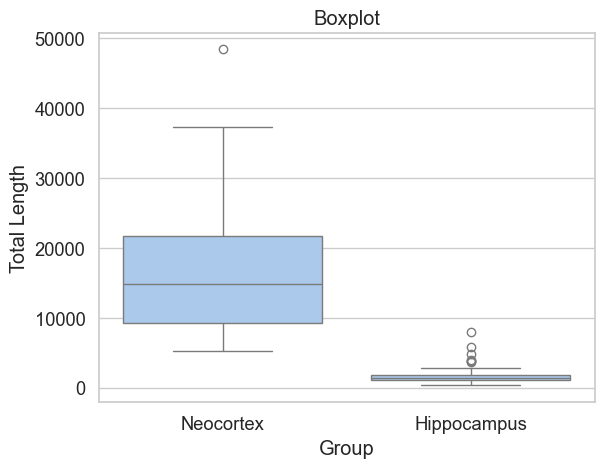

In [10]:
# plot 
data = pd.DataFrame({
    'Total Length': pd.concat([df_neocortex_length.iloc[:, -1], df_hippocampus_length.iloc[:, -1]], ignore_index=True),
    'Group': ['Neocortex'] * len(df_neocortex_length) + ['Hippocampus'] * len(df_hippocampus_length)
})

# Plot the boxplot
sns.boxplot(data=data, x='Group', y='Total Length')
plt.title('Boxplot')
plt.show()

Structural count average in neurons

In [11]:
# Node count by type
type_mapping = {2: 'Axon', 3: 'Basal Dendrite', 4: 'Apical Dendrite'}
df_neocortex['Structure'] = df_neocortex['Type'].map(type_mapping)
df_hippocampus['Structure'] = df_hippocampus['Type'].map(type_mapping)
neocortex_node_mean = df_neocortex['Structure'].value_counts()/82
hippocampus_node_mean = df_hippocampus['Structure'].value_counts()/71
print(neocortex_node_mean,hippocampus_node_mean)

Structure
Axon              11960.329268
Basal Dendrite     2073.195122
Name: count, dtype: float64 Structure
Basal Dendrite    709.901408
Axon              224.338028
Name: count, dtype: float64


C:\Users\bg24678\AppData\Local\Temp\ipykernel_56472\2113811480.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_up = pd.concat([data_up, match], ignore_index=True)
C:\Users\bg24678\AppData\Local\Temp\ipykernel_56472\2113811480.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_up = pd.concat([data_up, match], ignore_index=True)
C:\Users\bg24678\AppData\Local\Temp\ipykernel_56472\2604936982.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Axon 3.4627950174145544e-34
Basal Dendrite nan


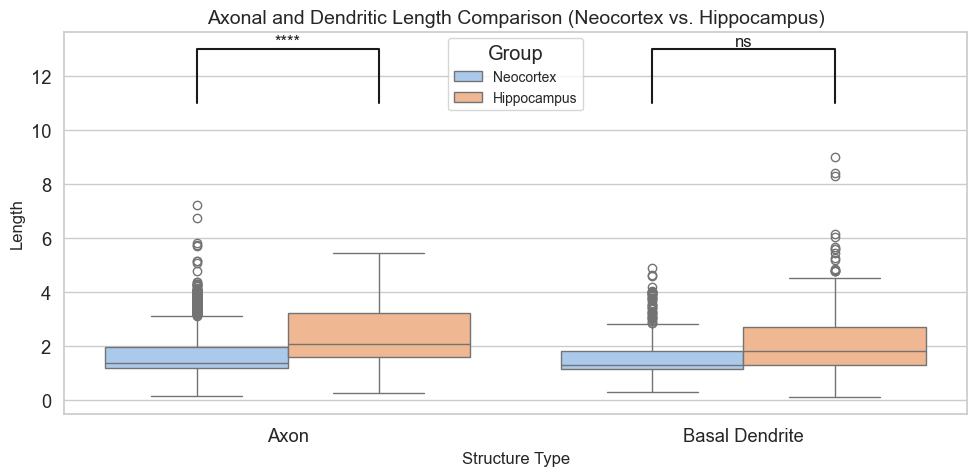

In [12]:
# Step 1: Load SWC data for neocortex and hippocampus -- select only 5% of data randomly
data_neocortex = df_neocortex.sample(frac=0.005, random_state=42)
data_hippocampus = df_hippocampus.sample(frac=0.005, random_state=42)

# Step 2: Map types to meaningful names
type_mapping = {2: 'Axon', 3: 'Basal Dendrite', 4: 'Apical Dendrite'}

for data in [data_neocortex, data_hippocampus]:
    data['Structure'] = data['Type'].map(type_mapping)

# Step 3: Process each dataset to calculate 'Length'
def process_data(data, df_org):
    data_up = pd.DataFrame(columns=data.columns)
    
    for _, row in data.iterrows():
        if row['Parent'] == -1:
            # If Parent is -1, create a row with NaNs for that entry
            data_up = pd.concat([data_up, pd.DataFrame([{col: np.nan for col in data.columns}])], ignore_index=True)
        else:
            # Match the row with the corresponding parent in df_other
            match = df_org[(df_org['ID'] == row['Parent']) & (df_org['File'] == row['File'])]
            
            if not match.empty:
                # If a match is found, append the matching row from df_other
                data_up = pd.concat([data_up, match], ignore_index=True)
            else:
                # If no match is found, create a row of NaNs for that entry
                data_up = pd.concat([data_up, pd.DataFrame([{col: np.nan for col in data.columns}])], ignore_index=True)

    # Reset index and drop rows with NaN values
    data = data.reset_index(drop=True).dropna()
    data_up = data_up.reset_index(drop=True).dropna()

    # Calculate the Length based on the differences in X, Y, Z coordinates
    data['Length'] = np.sqrt((data["X"] - data_up["X"])**2 + 
                             (data["Y"] - data_up["Y"])**2 + 
                             (data["Z"] - data_up["Z"])**2)
    return data


data_neocortex = process_data(data_neocortex,df_neocortex)
data_hippocampus = process_data(data_hippocampus,df_hippocampus)

# Step 4: Remove Group 0 and Combine Datasets
data_neocortex['Group'] = 'Neocortex'
data_hippocampus['Group'] = 'Hippocampus'

# Filter out invalid rows
data_neocortex = data_neocortex[data_neocortex['Structure'].notna()]
data_hippocampus = data_hippocampus[data_hippocampus['Structure'].notna()]

combined_data = pd.concat([data_neocortex, data_hippocampus], ignore_index=True)
combined_data = combined_data[combined_data['Group'] != 0]

# Step 5: Perform Statistical Analysis
p_values = {}
structures = ['Axon', 'Basal Dendrite']

# Dictionary for significance markers
significance_markers = {0.05: '*', 0.01: '**', 0.001: '***', 0.0001: '****'}

for structure in structures:
    group1_values = remove_outliers_zscore(combined_data[(combined_data['Structure'] == structure) & 
                                  (combined_data['Group'] == 'Neocortex')],'Length')['Length']
    group2_values = remove_outliers_zscore(combined_data[(combined_data['Structure'] == structure) & 
                                  (combined_data['Group'] == 'Hippocampus')],'Length')['Length']
    # Perform ANOVA
    _, p_value = f_oneway(group1_values.dropna(), group2_values.dropna())
    # Store p-value
    p_values[structure] = p_value
   
# Step 6: Create Box Plot with Significance Annotations
plt.figure(figsize=(10, 5))
sns.boxplot(x='Structure', y='Length', hue='Group', data=combined_data, palette='pastel')

# Add significance annotations
y_max = combined_data['Length'].max()
for idx, structure in enumerate(structures):
    p_value = p_values[structure]
    print(structure, p_value)
    if p_value < 0.0001:
        marker = '****'
    else:
        marker = next((m for t, m in significance_markers.items() if p_value <= t), 'ns')  # Default 'ns'
    x1, x2 = idx - 0.2, idx + 0.2  # x-positions for the two groups
    y, h = y_max + 2, 2  # y-level for annotation
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c='k')
    plt.text((x1 + x2) / 2, y + h, marker, ha='center', va='bottom', color='k', fontsize=12)

# Finalize the plot
plt.title('Axonal and Dendritic Length Comparison (Neocortex vs. Hippocampus)', fontsize=14)
plt.xlabel('Structure Type', fontsize=12)
plt.ylabel('Length', fontsize=12)
plt.legend(title='Group', fontsize=10)
plt.tight_layout()
plt.show()


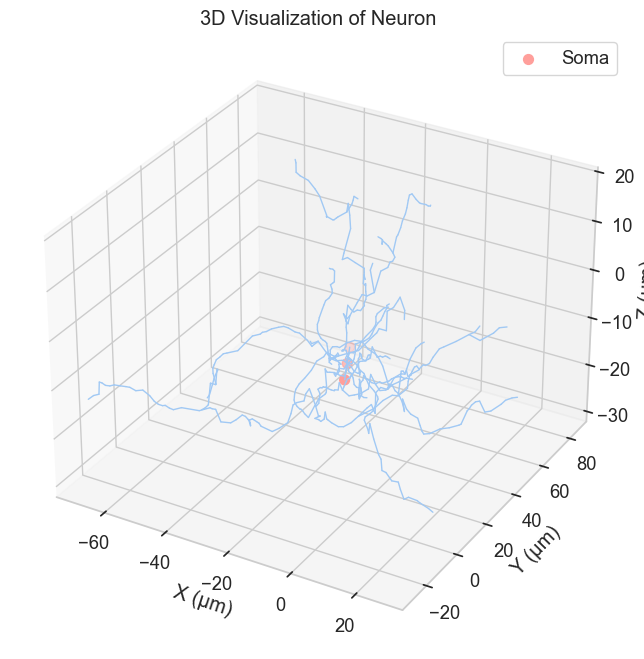

In [13]:
# Loading and visualizing - Hippocampus
swc_file = "p73_vGluT2-ctrl_IN04.CNG.swc"
df_view = read_swc(os.path.join("data", "anstoetz","CNG version",swc_file))
visualize_neuron(df_view)

Soma radius comparison

In [14]:
# Soma radius from SWC file
soma_radius_neocortex = df_neocortex.loc[df_neocortex['Type'] == 1, 'Radius'].mean()
soma_radius_hippocampus = df_hippocampus.loc[df_hippocampus['Type'] == 1, 'Radius'].mean()
print('Mean:', soma_radius_neocortex,soma_radius_hippocampus)

# Perform the t-test
t_stat, p_value = ttest_ind(df_neocortex.loc[df_neocortex['Type'] == 1, 'Radius'], df_hippocampus.loc[df_hippocampus['Type'] == 1, 'Radius'],)
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

Mean: 16.94218837092732 7.02623943661972
T-statistic: 9.3339
P-value: 0.0000


Maximum branching

In [15]:
# Calculate the maximum branching order per neuron
def calculate_branch_order(swc_data):
    branch_order = {}
    for _, row in swc_data.iterrows():
        parent = row['Parent']
        if parent not in branch_order:
            branch_order[row['ID']] = 0
        else:
            branch_order[row['ID']] = branch_order[parent] + 1
    return max(branch_order.values())

def process_batch_branch_order(directory):
    """
    Reads a batch of SWC files in a directory and analyzes them.
    """
    results = []
    for file_name in os.listdir(directory):
        if file_name.endswith(".swc"):
            file_path = os.path.join(directory, file_name)
            df = read_swc(file_path)
            branch_order = calculate_branch_order(df)
            results.append({"File": file_name, "Branch Order": branch_order})
    return pd.DataFrame(results)

# apply
df_neocortex_bo = process_batch_branch_order(os.path.join("data", "allen cell types","CNG version"))
df_hippocampus_bo = process_batch_branch_order(os.path.join("data", "anstoetz","CNG version"))

In [16]:
# Perform the t-test
t_stat, p_value = ttest_ind(df_neocortex_bo['Branch Order'], df_hippocampus_bo['Branch Order'])
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

T-statistic: 8.2125
P-value: 0.0000
